In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, models, compiling, optimizers
reload(TN_utils)
reload(models)

Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN not available)


<module 'scripts.core.models' from '/home/matsui-k/projects/d-rcn/scripts/core/models.pyc'>

In [2]:
fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=1, i_indiv=0, mask_thresh=0.5)
data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(fe_vec, gt_vec, mask_vec)

(430080, 43, 10) (430080, 10) (430080,)
(21485, 10, 43)
(21485, 10)
(5372, 10, 43)
(5372, 10)


In [ ]:
rcn_2layer = models.Rcn2layer_with_tensor_coupling(
    n_tensors_list=[fe_vec.shape[1], 341],
    func_key_list=["relu", "linear"],
    l2_reg=0.,
    gamma_scale=10**-2,
    drop_list=[1., 1.],
    bias_scale=0.)
                            
result = compiling.compile_bn(
    data_set=data_set,
    model=rcn_2layer,
    make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, s_input, s_target, s_test_input, s_test_target, param_list= result

batch_size = 512
N = s_input.get_value(borrow=True).shape[0]
batch_size = batch_size
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = data_set[2].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 101
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.99
        print i_epoch, training_error, test_error
print time.clock() - start_time

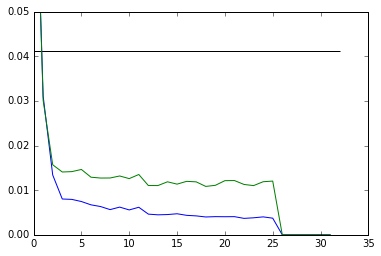

In [16]:
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.05)
plt.hlines(0.0411, 0, training_error_array.shape[0])

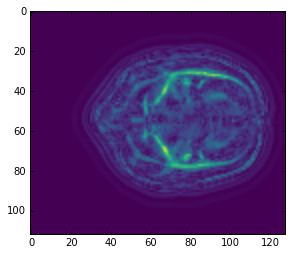

In [17]:
pred_train = TN_utils.predict_original_feature(f_output, fe_vec, norm_coef)
pred_train_vol = pred_train.reshape(vol_shape+(pred_train.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_train_vol, axis=0)[:, :, 15])

(430080, 43, 10)


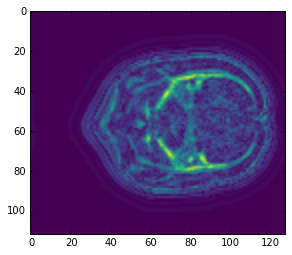

In [11]:
fe_test = TN_utils.load_hardi(i_order=1, i_indiv=1, only_feature=True)
pred_test = TN_utils.predict_original_feature(f_output, fe_test, norm_coef)
pred_test_vol = pred_test.reshape(vol_shape+(pred_test.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_test_vol, axis=0)[:, :, 15])

In [14]:
sio.savemat('../../../results/hardi_in_ex/July6/a2_all_train_1506.mat', {'pred' : pred_train_vol}) 
sio.savemat('../../../results/hardi_in_ex/July6/a2_all_test_1507.mat', {'pred' : pred_test_vol})